# Imports and setting up viz

NB : conda lam1env (Python3.12)

In [94]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import personnal tools
import sys
sys.path.append('../../python_tools/')
from tools import *
from tools_mapping import *
from tools_hf import *
from tools_native import *
from tools_LIAISE import *
from tools_mesoNH import *

# sys.path.append('../../python_tools/aborella/PLOTS/')
# from datasets import *
sys.path.append('../../python_tools/aborella/UTIL/')
import xr_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<unknown>:369: SyntaxWarning: invalid escape sequence '\s'
<unknown>:369: SyntaxWarning: invalid escape sequence '\s'


In [95]:
psy.rcParams['auto_show'] = True
mpl.rcParams['figure.figsize'] = [10., 8.]

# Load files

## LIAISE site obs

In [96]:
#load all July obs in one ds
cen_mto_filename='../../../obs/LIAISE/LIAISE_LA-CENDROSA_CNRM_MTO-FLUX-30MIN_L2/LIAISE_LA-CENDROSA_CNRM_MTO-FLUX-30MIN_L2_2021-07*_V3.nc'
cen_mto = format_Cendrosa_obs(cen_mto_filename)
cen_mto

<xarray.Dataset> Size: 708kB
Dimensions:                (time: 1488, level: 2)
Coordinates:
  * time                   (time) datetime64[ns] 12kB 2021-07-01T00:30:00 ......
    time_decimal           (time) float64 12kB 0.5 1.0 1.5 2.0 ... 23.0 23.5 0.0
Dimensions without coordinates: level
Data variables: (12/112)
    time_bnds              (time, level) datetime64[ns] 24kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    Qg                     (time) float32 6kB dask.array<chunksize=(48,), meta=np.ndarray>
    precip                 (time) float32 6kB dask.array<chunksize=(48,), meta=np.ndarray>
    soil_temp_06           (time) float32 6kB dask.array<chunksize=(48,), meta=np.ndarray>
    soil_temp_12           (time) float32 6kB dask.array<chunksize=(48,), meta=np.ndarray>
    soil_temp_3            (time) float32 6kB dask.array<chunksize=(48,), meta=np.ndarray>
    ...                     ...
    w_v_cov_1              (time) float32 6kB dask.array<chunksize=(48,), meta=np.ndarray>
    w_v_cov_2              (time) float32 6kB dask.array<chunksize=(48,), meta=np.ndarray>
    w_v_cov_3              (time) float32 6kB dask.array<chunksize=(48,), meta=np.ndarray>
    lwnet                  (time) float32 6kB dask.array<chunksize=(48,), meta=np.ndarray>
    swnet                  (time) float32 6kB dask.array<chunksize=(48,), meta=np.ndarray>
    mrsos                  (time) float32 6kB dask.array<chunksize=(48,), meta=np.ndarray>
Attributes: (12/36)
    creator_name:              William Maurel
    creator_email:             contact.tramm-cnrm@meteo.fr
    acqid:                     Ce210182
    processing_level:          L2
    nom_aeris:                 LA-CENDROSA
    doi:                       https//doi.org/10.25326/320
    ...                        ...
    geospatial_lon_max:        0.92841
    geospatial_lat_min:        41.69336
    geospatial_lat_max:        41.69336
    name:                      Cendrosa obs
    plot_color:                black
    linestyle:                 -

In [97]:
start_time = '2021-07-14T01:00:00'
end_time = '2021-07-30T23:00:00'
restrict_cen_mto = filter_xarray_by_timestamps(cen_mto, start_time, end_time)

In [98]:
filename =  '../../../obs/LIAISE/LIAISE_ELS-PLANS_UKMO_MTO-30MIN_L2/LIAISE_ELS-PLANS_UKMO_MTO-30MIN_L2_20210721_V4.0.dat'
ds = dat_to_xarray(filename, 152, 153)
els_mto_2107 = format_ElsPlans_obs(ds, start_day='2021-07-21')

filename =  '../../../obs/LIAISE/LIAISE_ELS-PLANS_UKMO_MTO-30MIN_L2/LIAISE_ELS-PLANS_UKMO_MTO-30MIN_L2_20210722_V4.0.dat'
ds = dat_to_xarray(filename, 152, 153)
els_mto_2207 = format_ElsPlans_obs(ds, start_day='2021-07-22')

/home/ptiengou/miniconda3/envs/lam1env/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/home/ptiengou/miniconda3/envs/lam1env/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


In [99]:
july_days=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']
for day in july_days:
    filename =  '../../../obs/LIAISE/LIAISE_ELS-PLANS_UKMO_MTO-30MIN_L2/LIAISE_ELS-PLANS_UKMO_MTO-30MIN_L2_202107{}_V4.0.dat'.format(day)
    ds = dat_to_xarray(filename, 152, 153)
    day_els_mto = format_ElsPlans_obs(ds, start_day='2021-07-{}'.format(day))
    if day=='01':
        els_mto=day_els_mto
    else:
        els_mto=xr.concat([els_mto,day_els_mto],dim='time')
els_mto

/home/ptiengou/miniconda3/envs/lam1env/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/home/ptiengou/miniconda3/envs/lam1env/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/home/ptiengou/miniconda3/envs/lam1env/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/home/ptiengou/miniconda3/envs/lam1env/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/home/ptiengou/miniconda3/envs/lam1env/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/home/ptiengou/miniconda3/envs/lam1env/lib/python3.12/site-packages/xarray/

<xarray.Dataset> Size: 2MB
Dimensions:             (time: 1488)
Coordinates:
  * time                (time) datetime64[ns] 12kB 2021-07-01T00:15:00 ... 20...
    time_decimal        (time) float64 12kB 0.25 0.75 1.25 ... 22.75 23.25 23.75
Data variables: (12/153)
    UTOT_50m            (time) float64 12kB 2.161 2.616 1.718 ... nan nan nan
    USCL_50m            (time) float64 12kB 2.218 2.678 1.889 ... nan nan nan
    UMAX_50m            (time) float64 12kB 4.837 5.374 4.618 ... nan nan nan
    DIR_50m             (time) float64 12kB 160.5 139.8 124.5 ... nan nan nan
    t50m                (time) float64 12kB 20.09 19.89 20.08 ... nan nan nan
    UU_50m              (time) float64 12kB 0.407 0.7082 0.7065 ... nan nan nan
    ...                  ...
    flat                (time) float64 12kB -1.648 -3.088 1.919 ... nan nan nan
    sens                (time) float64 12kB -13.23 -14.36 -15.28 ... nan nan nan
    lwnet               (time) float64 12kB -61.71 -60.65 ... -70.18 -70.23
    swnet               (time) float64 12kB -0.1837 -0.1867 ... -0.006581 0.2021
    mrsos               (time) float64 12kB 12.99 12.96 12.95 ... 23.35 23.33
    q2m                 (time) float64 12kB -1.646e+03 -1.646e+03 ... nan nan
Attributes:
    name:        ElsPlans obs
    plot_color:  black
    linestyle:   --

In [100]:
restrict_els_mto = filter_xarray_by_timestamps(els_mto, start_time, end_time)

## MesoNH sim

In [101]:
mesoNH_dir = '../../../mesoNH_simulations'

In [102]:
def format_MesoNH_outputs_basic(filename, ds_name=None):
    ds = xr.open_mfdataset(filename)
    ds.attrs['name']= ds_name

    rename_dict={
        'time':'start_time',
        'longitude':'lon',
        'latitude':'lat'
    }
    ds = ds.rename(rename_dict)

    # Add time coordinate
    # Assuming 'time' coordinate is the starting time.
    base_time = pd.to_datetime(ds["start_time"].isel(start_time=0).item())
    print(f"Base time for the dataset: {base_time}")
    # Create a timedelta for each hour
    hourly_offsets = pd.to_timedelta(ds["record"].values, unit='h')
    new_time_vals = base_time + hourly_offsets
    # Assign new_time as a new coordinate, linked to the 'record' dimension
    ds = ds.assign_coords(time=("record", new_time_vals))
    ds = ds.swap_dims({"record": "time"})
    #drop start_time and record
    ds = ds.drop_vars(['start_time'])
    ds = ds.assign_coords(time_decimal=ds.time.dt.hour + ds.time.dt.minute / 60)

    if 'LE_ISBA' in ds:
        ds = ds.rename({'LE_ISBA': 'flat'})
        ds['flat'].attrs['long_name'] = 'Latent Heat Flux on natural areas'
        ds['flat'].attrs['units'] = 'W m⁻²'
    if 'H_ISBA' in ds:
        ds = ds.rename({'H_ISBA': 'sens'})
        ds['sens'].attrs['long_name'] = 'Sensible Heat Flux on natural areas'
        ds['sens'].attrs['units'] = 'W m⁻²'
    if 'HU2M_ISBA' in ds:
        ds['rh2m'] = ds['HU2M_ISBA'] * 100.0 
        ds['rh2m'].attrs['long_name'] = 'Relative Humidity at 2m'
        ds['rh2m'].attrs['units'] = '%'
    if 'T2M_ISBA' in ds:
        ds = ds.rename({'T2M_ISBA': 't2m'})
        ds['t2m'].attrs['long_name'] = 'Temperature at 2m'
        ds['t2m'] = ds['t2m'] - 273.15
        ds['t2m'].attrs['units'] = '°C'
    if 'SWD' in ds:
        #remove dimension 'start_time' from SWD
        ds['SWD'] = ds['SWD'].squeeze('start_time', drop=True)
        ds = ds.rename({'SWD': 'SWdnSFC'})
        ds['SWdnSFC'].attrs['long_name'] = 'Downward Shortwave Radiation at Surface'
        ds['SWdnSFC'].attrs['units'] = 'W m⁻²'
    if 'LWD' in ds:
        #remove dimension 'start_time' from LWD
        ds['LWD'] = ds['LWD'].squeeze('start_time', drop=True)
    if 'LWU' in ds:
        #remove dimension 'start_time' from LWU
        ds['LWU'] = ds['LWU'].squeeze('start_time', drop=True)
    if 'SWU' in ds:
        #remove dimension 'start_time' from SWU
        ds['SWU'] = ds['SWU'].squeeze('start_time', drop=True)
    if 'HBLTOP' in ds:
        #remove dimension 'start_time' from HBLTOP
        ds['HBLTOP'] = ds['HBLTOP'].squeeze('start_time', drop=True)

    #add specific humidity at 2m
    # ds=add_specific_humidity_2m(ds, assume_psol=True)

    return(ds)

In [103]:
filename='{}/LIAIS.1*.nc'.format(mesoNH_dir)
# filename='{}/LIAIS.1.UT10.nc'.format(mesoNH_dir)
mesoNH = format_MesoNH_outputs_basic(filename)
mesoNH

Base time for the dataset: 2021-07-14 01:00:00


<xarray.Dataset> Size: 2GB
Dimensions:       (time: 408, nj: 164, ni: 290)
Coordinates:
  * ni            (ni) float64 2kB 0.0 2e+03 4e+03 ... 5.76e+05 5.78e+05
  * nj            (nj) float64 1kB 0.0 2e+03 4e+03 ... 3.24e+05 3.26e+05
    lat           (nj, ni) float64 380kB dask.array<chunksize=(164, 290), meta=np.ndarray>
    lon           (nj, ni) float64 380kB dask.array<chunksize=(164, 290), meta=np.ndarray>
  * time          (time) datetime64[ns] 3kB 2021-07-14T01:00:00 ... 2021-07-31
    time_decimal  (time) float64 3kB 1.0 2.0 3.0 4.0 5.0 ... 21.0 22.0 23.0 0.0
Data variables: (12/14)
    HBLTOP        (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    HU2M_ISBA     (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    sens          (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    flat          (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    LWD           (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    LWU           (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    ...            ...
    SWI3_ISBA     (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    SWU           (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    t2m           (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    TG1_ISBA      (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    TG3_ISBA      (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    rh2m          (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
Attributes:
    MNH_cleanly_closed:  yes
    history:             Thu Jun 12 15:36:26 2025: ncecat -v HBLTOP,time,lati...
    NCO:                 netCDF Operators version 5.2.1 (Homepage = http://nc...
    name:                None

In [104]:
load_4D=False
def format_MesoNH_outputs_4D(filename, ds_name=None):
    ds = xr.open_mfdataset(filename)
    ds.attrs['name']= ds_name


    rename_dict={
        # 'time':'start_time',
        'longitude':'lon',
        'latitude':'lat'
    }
    ds = ds.rename(rename_dict)

    # Add time coordinate
    # Assuming 'time' coordinate is the starting time.
    # base_time = pd.to_datetime(ds["start_time"].isel(start_time=0).item())
    # print(f"Base time for the dataset: {base_time}")
    # Create a timedelta for each hour
    # hourly_offsets = pd.to_timedelta(ds["record"].values, unit='h')
    # new_time_vals = base_time + hourly_offsets
    # # Assign new_time as a new coordinate, linked to the 'record' dimension
    # ds = ds.assign_coords(time=("record", new_time_vals))
    # ds = ds.swap_dims({"record": "time"})
    # #drop start_time and record
    # ds = ds.drop_vars(['start_time'])
    # ds = ds.assign_coords(time_decimal=ds.time.dt.hour + ds.time.dt.minute / 60)

    return ds

if load_4D:
    filename='{}/4D/LIAIS.1*.nc'.format(mesoNH_dir)
    mesoNH_4D = format_MesoNH_outputs_4D(filename)

In [ ]:
mesoNH_4D

## Subdataset for ICOLMDZ grid cells

In [105]:
mesoNH_elsplans_cell= subset_dataset_by_polygon(mesoNH, elsplans_cell, 
                                            name='ElsPlans mesoNH_mean',
                                            plot_color='orange')
mesoNH_cendrosa_cell= subset_dataset_by_polygon(mesoNH, cendrosa_cell, 
                                            name='Cendrosa mesoNH_mean',
                                            plot_color='orange')

In [106]:
#select subdataset for precisely each site
cendrosa_exact = select_dataset_lon_lat(mesoNH, 
                                        lon=Cendrosa_Longitude, lat=Cendrosa_Latitude, 
                                        name='Cendrosa mesoNH_exact',
                                        plot_color='purple')

In [107]:
elsplans_exact = select_dataset_lon_lat(mesoNH, 
                                        lon=ElsPlans_Longitude, lat=ElsPlans_Latitude, 
                                        name='ElsPlans mesoNH_exact', 
                                        plot_color='purple')

## Load LMDZ files

In [108]:
nat_dir='../../../JZ_simu_outputs/LAM/LAM_1500_60/halfhour_native'

boost_irrig_dir= '../../../JZ_simu_outputs/LAM/LAM_1500_60/boost_irrig'

In [109]:
noirr=True
irr100=True
routing_restart_full_beta1=True


In [110]:
#load LMDZ
if noirr:
    lmdz_noirr_file = '{}/sim267_20210701_20210731_HF_histhf.nc'.format(nat_dir)
    lmdz_noirr = format_lmdz_HF(lmdz_noirr_file, 'red', 'noirr')
    lmdz_noirr = lmdz_noirr.sel(time=slice('2021-07-14', '2021-07-30'))
    cen_lmdz_noirr, els_lmdz_noirr  , sop_cen_lmdz_noirr,   sop_els_lmdz_noirr = select_liaise_sites_sop(lmdz_noirr, 'no_irr')


In [111]:
if irr100:
    dir=boost_irrig_dir
    sim_name='sim275'
    color='blue'
    label='irr'

    lmdz_irr100_file = '{}/{}_20210701_20210731_HF_histhf.nc'.format(dir, sim_name)
    lmdz_irr100 = format_lmdz_HF(lmdz_irr100_file, color, label)
    lmdz_irr100 = lmdz_irr100.sel(time=slice('2021-07-14', '2021-07-30'))
    cen_lmdz_irr100, els_lmdz_irr100  , sop_cen_lmdz_irr100,   sop_els_lmdz_irr100 = select_liaise_sites_sop(lmdz_irr100, label)


In [112]:
if routing_restart_full_beta1 :
    dir=boost_irrig_dir
    sim_name='sim293'
    color='green'
    label='irr_boost'

    lmdz_routingfull_beta1_file = '{}/{}_20210701_20210731_HF_histhf.nc'.format(dir, sim_name)
    lmdz_routingfull_beta1 = format_lmdz_HF(lmdz_routingfull_beta1_file, color, label)
    lmdz_routingfull_beta1 = lmdz_routingfull_beta1.sel(time=slice('2021-07-14', '2021-07-30'))
    cen_lmdz_routingfull_beta1, els_lmdz_routingfull_beta1, sop_cen_lmdz_routingfull_beta1, sop_els_lmdz_routingfull_beta1 = select_liaise_sites_sop(lmdz_routingfull_beta1, label)

# Tests

## Maps

In [113]:
ds=ds_4D
level=2.000000e+00
var='RVT'

mean_ds = ds[var].mean(dim='time')
mean_ds = mean_ds[0,:,:]  # Select the specific level
# mean_ds
nice_map_mesoNH(mean_ds)

NameError: name 'ds_4D' is not defined

In [ ]:
var='flat'
vmin=0
vmax=500
# vmin,vmax=None, None
cmap=blues
map_mesoNH_timestamp_restrict(mesoNH, 
                     var,
                     vmin=vmin, vmax=vmax, cmap=cmap,
                     timestamp='2021-07-20T12:00:00',
                     add_liaise=True,
                    lon_min=0.6, 
                    lon_max=1.4, 
                    lat_min=41.37, 
                    lat_max=41.92,
                    poly=both_cells
                     )

In [ ]:
#list of all variables names in mesoNH
# mesoNH.data_vars.keys()
varlist=['HBLTOP', 'sens', 'flat', 'rh2m', 't2m',  'LWD', 'LWU', 'SWdnSFC',
          'SWI1_ISBA', 'SWI3_ISBA', 'TG1_ISBA', 'TG3_ISBA']

In [ ]:
for var in varlist:
    vmin=0
    vmax=500
    vmin,vmax=None, None
    cmap=blues
    map_mesoNH_timestamp_restrict(mesoNH, 
                        var,
                        vmin=vmin, vmax=vmax, cmap=cmap,
                        timestamp='2021-07-20T12:00:00',
                        add_liaise=True,
                        # lon_min=0.6, 
                        # lon_max=1.4, 
                        # lat_min=41.37, 
                        # lat_max=41.92,
                        # poly=both_cells
                        )

In [ ]:
var='flat'
vmin=-0
vmax=200
# vmin,vmax=None, None
cmap=blues
map_mesoNH_mean_restrict(mesoNH, 
                 var,
                 vmin=vmin, vmax=vmax, cmap=cmap,
                 title='ISBA latent heat flux mean (14-31 July)',
                 add_liaise=True,
                lon_min=0.6, 
                lon_max=1.4, 
                lat_min=41.37, 
                lat_max=41.92,
                poly=both_cells,
                label='Latent heat flux (W m⁻²)',
                 )

In [ ]:
map_mesoNH_timestamp(mesoNH_elsplans_cell,
                 var='flat',
                 vmin=0, vmax=250, cmap=myvir,
                #  title='Latent Heat Flux mean (14-31/07/2021) in Ebro basin',
                 add_liaise=True,
                 timestamp='2021-07-20T12:00:00',
                 )

In [ ]:
ds=mesoNH_cendrosa_cell
# ds=mesoNH_elsplans_cell
timestamp='2021-07-20T12:00:00'
var='sens'
xmin=0
xmax=550
nbins=11
bins_timestamp(ds, var, timestamp, nbins=nbins, xmin=xmin, xmax=xmax)

In [ ]:
ds=mesoNH_cendrosa_cell
ds=mesoNH_elsplans_cell
# timestamp='2021-07-20T12:00:00'
var='flat'
xmin=0
xmax=525
nbins=21
title='Distribution of mean latent heat flux at 12UTC (14-31/07/2021)'
xlabel='Latent heat flux (W m⁻²)'
bins_hour(ds, var, 12, nbins=nbins, xmin=xmin, xmax=xmax, 
          title=title, xlabel=xlabel)

In [ ]:
vars=['flat', 'sens']
ds1=cendrosa_exact
ds2=mesoNH_cendrosa_cell
ds3=cen_lmdz_noirr
ds4=cen_lmdz_irr100
ds5=cen_lmdz_routingfull_beta1
ds6=cen_mto

ds8=elsplans_exact
ds9=mesoNH_elsplans_cell
ds10=els_lmdz_noirr
ds11=els_lmdz_irr100
ds12=els_lmdz_routingfull_beta1
ds13=els_mto

for var in vars:
    for ds in [ds1, ds2, ds3, ds4, ds5, ds6, ds8, ds9, ds10, ds11, ds12, ds13]:
            mean = mean_value_hour(ds, var, 12)
            print(f"{ds.name} - {var} at 12 UTC: {mean:.2f} W m⁻²")

## Time series

/home/ptiengou/Documents/data_and_scripts/netcdf-scripts/python_notebooks/MANUSCRIT/../../python_tools/tools.py:833: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


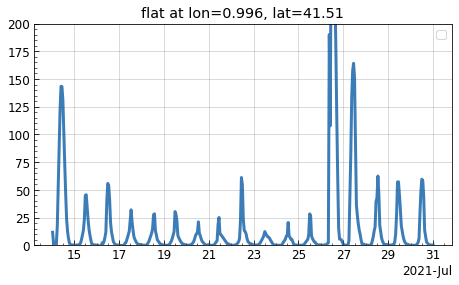

In [ ]:
var='t2m'
ds=mesoNH
vmin=0
vmax=200
time_series_lonlat_mesoNH(ds, var, 
                          lon=ElsPlans_lon, 
                          lat=ElsPlans_lat,
                          vmin=vmin, vmax=vmax
                          )

/home/ptiengou/Documents/data_and_scripts/netcdf-scripts/python_notebooks/MANUSCRIT/../../python_tools/tools.py:833: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


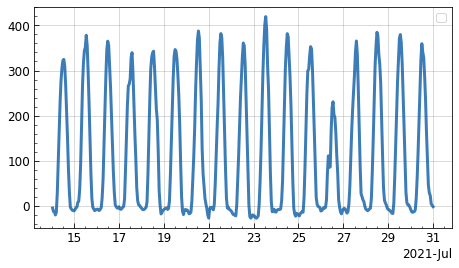

In [ ]:
var='sens'
ds=mesoNH_cendrosa_cell
ds=mesoNH_elsplans_cell
vmin=0
vmax=200
vmin,vmax=None, None
time_series_ave_mesoNH(ds, var, 
                    #    vmin=vmin, vmax=vmax
                       )

### TS and DC

In [114]:
var='t2m'
ds1= cen_lmdz_noirr
ds2= cen_lmdz_irr100
ds3= cen_lmdz_routingfull_beta1
ds4=mesoNH_cendrosa_cell
ds5=cendrosa_exact
ds6=restrict_cen_mto

# ds1= els_lmdz_noirr
# ds2= els_lmdz_irr100
# ds3= els_lmdz_routingfull_beta1
# ds4=mesoNH_elsplans_cell
# ds5=elsplans_exact
# ds6=restrict_els_mto

ds4.attrs['show_envelope'] = True

# ds1['q2m'].attrs['long_name'] = '2-m specific humidity'

ds_list= [ds6, ds1, ds2, ds3, ds5, ds4]  
# ds_list=[ds6, ds1, ds2, ds3]  
ds_list=[ds1]

# title=f'{ds1[var].attrs['long_name']} ({ds1[var].attrs['units']})'
# if ds1[var].attrs['units'] == 'W m⁻²':
#     title=f'{ds1[var].attrs["long_name"]} (W m⁻²)'
title='off'

ylabel = ds1[var].attrs['long_name'] + ' (' + ds1[var].attrs['units'] + ')'

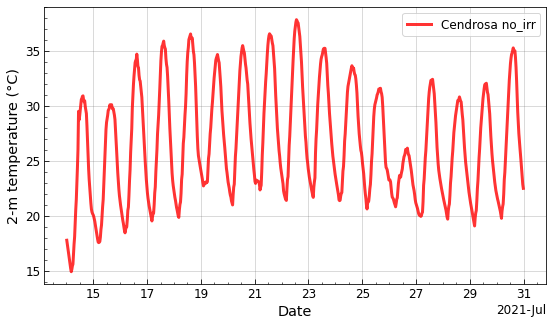

In [115]:
vmin=-0
vmax=100
vmin,vmax=None, None

time_series_ave(ds_list, var, 
                vmin=vmin, vmax=vmax,
                title=title,
                legend_out=False,
                xlabel='Date',
                ylabel=ylabel,
                ds_colors=True,
                figsize=(9, 5),
                envelope=False
                )

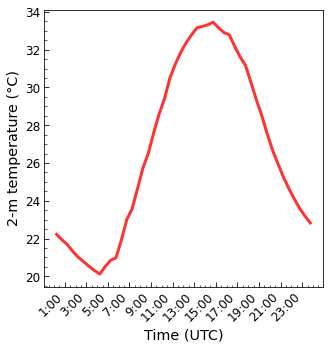

In [116]:
vmin=0
vmax=100
vmin,vmax=None, None

diurnal_cycle_ave(ds_list, var,
                 vmin=vmin, vmax=vmax,
                 title=title,
                 legend_out=None,
                 xlabel='Time (UTC)',
                 ylabel=ylabel,
                 ds_colors=True,
                figsize=(5,5),
                envelope=True
                 )

# Figures

## Surface variables on both sites, time series and mean diurnal cycle (15-31/07)

### Cendrosa

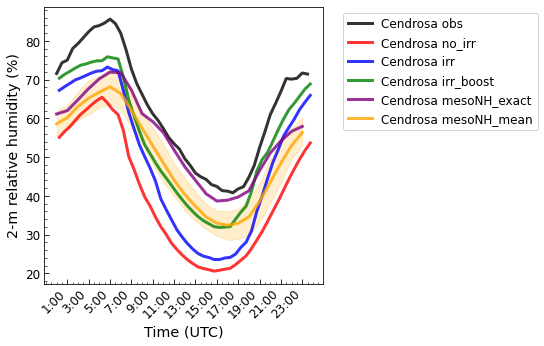

In [144]:
savefig=True
plot_TS=False

varlist=['flat', 'sens', 't2m']
varlist=['rh2m']

ds1= cen_lmdz_noirr
ds2= cen_lmdz_irr100
ds3= cen_lmdz_routingfull_beta1
ds4=mesoNH_cendrosa_cell
ds4.attrs['show_envelope'] = True
ds5=cendrosa_exact
ds6=restrict_cen_mto
ds_list= [ds6, ds1, ds2, ds3, ds5, ds4]  

title='off'

#TS
mins=[0,-150,15,0]
maxs=[700,450,35,0.015]
for var in varlist:
    if not plot_TS:
        break
    ylabel = ds1[var].attrs['long_name'] + ' (' + ds1[var].attrs['units'] + ')'
    vmin=mins[varlist.index(var)]
    vmax=maxs[varlist.index(var)]
    vmin,vmax=None, None
    time_series_ave(ds_list, var, 
                    vmin=vmin, vmax=vmax,
                    title=title,
                    legend_out=None,
                    xlabel='Date',
                    ylabel=ylabel,
                    ds_colors=True,
                    figsize=(9, 5),
                    envelope=False
                    )
    if savefig:
        plt.savefig(f'figures/chap5/time_series_cendrosa_{var}.png', dpi=300)

#DC
mins=[0,-150,15,0]
maxs=[520,420,35,0.015]
for var in varlist:
    ylabel = ds1[var].attrs['long_name'] + ' (' + ds1[var].attrs['units'] + ')'
    vmin=mins[varlist.index(var)]
    vmax=maxs[varlist.index(var)]
    vmin,vmax=None, None
    diurnal_cycle_ave(ds_list, var,
                     vmin=vmin, vmax=vmax,
                     title=title,
                     legend_out=True,
                     xlabel='Time (UTC)',
                     ylabel=ylabel,
                     ds_colors=True,
                    figsize=(5,5),
                    envelope=True
                     )
    if savefig:
        plt.savefig(f'figures/chap5/diurnal_cycle_cendrosa_{var}.png', dpi=300)

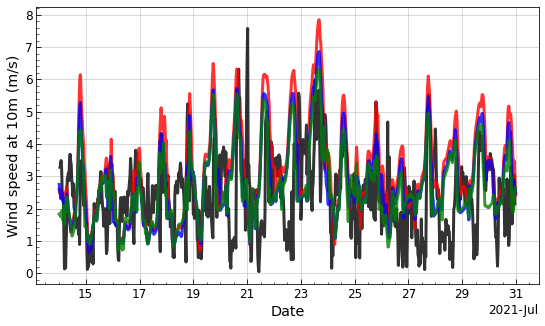

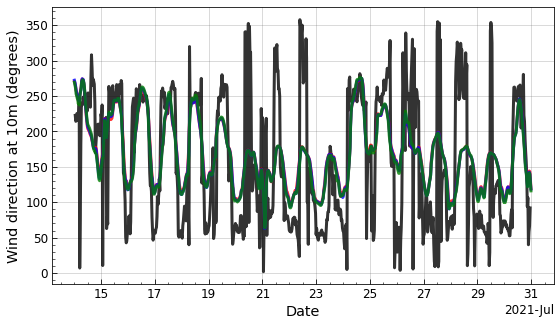

In [ ]:
#no mesoNH
savefig=True
plot_TS=True
plot_DC=True

varlist=['wind_speed_10m', 'wind_direction_10m']
varlist=['q2m']

ds1= cen_lmdz_noirr
ds2= cen_lmdz_irr100
ds3= cen_lmdz_routingfull_beta1
ds6=restrict_cen_mto
ds_list= [ds6, ds1, ds2, ds3]  

title='off'

#TS
for var in varlist:
    if not plot_TS:
        break
    ylabel = ds1[var].attrs['long_name'] + ' (' + ds1[var].attrs['units'] + ')'
    vmin=mins[varlist.index(var)]
    vmax=maxs[varlist.index(var)]
    vmin,vmax=None, None
    time_series_ave(ds_list, var, 
                    vmin=vmin, vmax=vmax,
                    title=title,
                    legend_out=None,
                    xlabel='Date',
                    ylabel=ylabel,
                    ds_colors=True,
                    figsize=(9, 5),
                    envelope=False
                    )
    if savefig:
        plt.savefig(f'figures/chap5/time_series_cendrosa_{var}.png', dpi=300)

#DC
for var in varlist:
    if not plot_DC:
        break
    ylabel = ds1[var].attrs['long_name'] + ' (' + ds1[var].attrs['units'] + ')'
    vmin=mins[varlist.index(var)]
    vmax=maxs[varlist.index(var)]
    vmin,vmax=None, None
    diurnal_cycle_ave(ds_list, var,
                     vmin=vmin, vmax=vmax,
                     title=title,
                     legend_out=True,
                     xlabel='Time (UTC)',
                     ylabel=ylabel,False
                     ds_colors=True,
                    figsize=(5,5),
                    envelope=True
                     )
    if savefig:
        plt.savefig(f'figures/chap5/diurnal_cycle_cendrosa_{var}.png', dpi=300)

### Els Plans

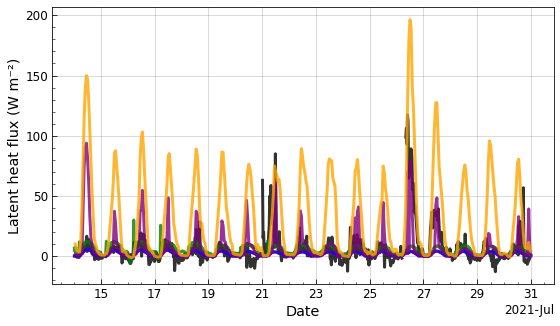

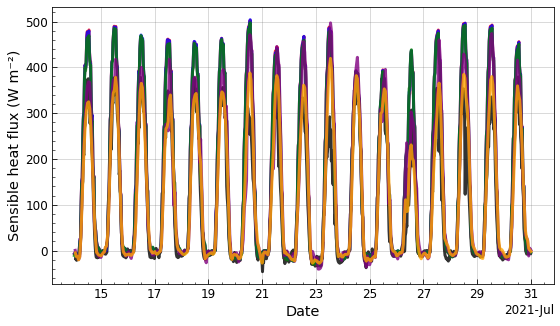

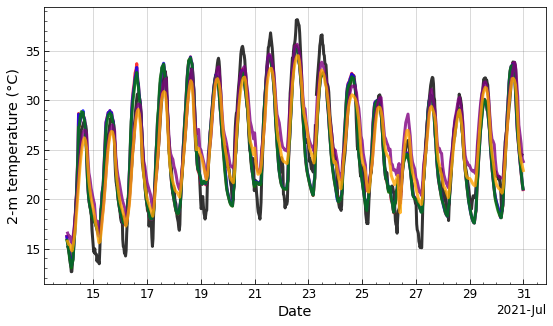

In [140]:
savefig=True
plot_TS=True
plot_DC=False

varlist=['flat', 'sens', 't2m']

ds1= els_lmdz_noirr
ds2= els_lmdz_irr100
ds3= els_lmdz_routingfull_beta1
ds4=mesoNH_elsplans_cell
ds4.attrs['show_envelope'] = True
ds5=elsplans_exact
ds6=restrict_els_mto
ds_list= [ds6, ds1, ds2, ds3, ds5, ds4]

title='off'
#TS
mins=[0,-150,15,0]
maxs=[700,450,35,0.015]
for var in varlist:
    if not plot_TS:
        break
    ylabel = ds1[var].attrs['long_name'] + ' (' + ds1[var].attrs['units'] + ')'
    vmin=mins[varlist.index(var)]
    vmax=maxs[varlist.index(var)]
    vmin,vmax=None, None
    time_series_ave(ds_list, var, 
                    vmin=vmin, vmax=vmax,
                    title=title,
                    legend_out=None,
                    xlabel='Date',
                    ylabel=ylabel,
                    ds_colors=True,
                    figsize=(9, 5),
                    envelope=False
                    )
    if savefig:
        plt.savefig(f'figures/chap5/time_series_elsplans_{var}.png', dpi=300)
#DC
mins=[0,-150,15,0]
maxs=[520,420,35,0.015]
for var in varlist:
    if not plot_DC:
        break
    ylabel = ds1[var].attrs['long_name'] + ' (' + ds1[var].attrs['units'] + ')'
    vmin=mins[varlist.index(var)]
    vmax=maxs[varlist.index(var)]
    vmin,vmax=None, None
    diurnal_cycle_ave(ds_list, var,
                     vmin=vmin, vmax=vmax,
                     title=title,
                     legend_out=True,
                     xlabel='Time (UTC)',
                     ylabel=ylabel,
                     ds_colors=True,
                    figsize=(5,5),
                    envelope=True
                     )
    if savefig:
        plt.savefig(f'figures/chap5/diurnal_cycle_elsplans_{var}.png', dpi=300)